<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>Challenge Loan Approval Prediction in Pennsylvania</h1>
    <h3>Carga y limpieza de los datos</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>


# Índice

1. [Importar librerias](#1.-Importar-librerias)  
2. [Funciones auxiliares](#2.-Funciones-auxiliares)  
3. [Carga del Dataset](#3.-Carga-del-Dataset)  
4. [Limpieza de los datos](#4.-Limpieza-de-los-datos)  
   * 4.1 [Estudio de las columnas](##4.1-Estudio-de-las-columnas)
   * 4.2 [Tratamiento de los duplicados y de los nulos](##4.2-Tratamiento-de-los-duplicados-y-de-los-nulos)
   * 4.3 [Tratamiento de las variables categóricas](##4.3-Tratamiento-de-las-variables-categoricas)
      * 4.3.1 [Tratamiento de las variables categóricas binarias](###4.3.1-Tratamiento-de-las-variables-categoricas-binarias)
      * 4.3.2 [Tratamiento de las variables categóricas no binarias](###4.3.2-Tratamiento-de-las-variables-categoricas-no-binarias)
5. [Correlacion](#5.-Correlacion)  
6. [Codificacion One-Hot](#6.-Codificacion-One-Hot)  
7. [Create Test](#7.-Create-Test)  
8. [Exportar CSV](#8.-Exportar-CSV)
9. [Referencias](#9.-Referencias)


# 1. Importar librerias

In [74]:
import pandas as pd
import numpy as np

from datetime import datetime
import json


import matplotlib.pyplot as plt
import seaborn as sns


import spacy
from spacy import displacy


# 2. Funciones auxiliares

In [75]:
def extract_month(date, mode=0):
    if pd.isna(date):
        return mode
    return datetime.strptime(date, '%d-%b-%y').month

In [76]:
def month_to_quarter(month):
    if month == 0:
        return 0
    return np.ceil(month / 3).astype(int)

In [77]:
def print_counts(dataframe_function):
    
    value_counts = dataframe_function.value_counts()
    sorted_values = sorted(value_counts.index)
    print("value_counts", ", ".join(sorted_values))
    print("\nNúmero de apariciones:\n", value_counts)


# 3. Carga del Dataset

In [78]:
url = "data/train.csv" 
data = pd.read_csv(url)
df = data.copy()

url2 = "data/test_nolabel.csv"
df_test = pd.read_csv(url2)

Configuramos Pandas para mostrar todas las columnas de un DataFrame al imprimirlo, y luego mostramos las primeras filas del DataFrame df.

In [79]:
pd.set_option('display.max_columns', None)
df.head()

,id,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,81f884c64a7,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,30c2723a188,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,6936b216e5d,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,b5cd9195738,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,84f8dac7737,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


Con *Info* desplegamos la información del dataframe para saber con que datos trabajaremos en cada una de las columnas

In [80]:
df.info

<bound method DataFrame.info of                id  label                                          statement  \
0     81f884c64a7      1  China is in the South China Sea and (building)...   
1     30c2723a188      0  With the resources it takes to execute just ov...   
2     6936b216e5d      0  The (Wisconsin) governor has proposed tax give...   
3     b5cd9195738      1  Says her representation of an ex-boyfriend who...   
4     84f8dac7737      0  At protests in Wisconsin against proposed coll...   
...           ...    ...                                                ...   
8945  44edff2b865      1  If Rhode Island does a hybrid [retirement] pla...   
8946  4a63b5f9c16      1  The new health care law will force seniors int...   
8947  7c57fa8e81c      0  The health insurance plan that (members of Con...   
8948  2375e3cf4b7      1  No one in American history has moved from a Ju...   
8949  5ae9b14e6e5      0  Says the Army is spending $7 million to sponso...   

                   

Gracias a *shape* podemos saber las dimensiones del dataframe, de esta maenra podemos saber la cantidad de filas que tenemos en un incio y la cantidad de columnas con las que trabajaremos

In [81]:
df.shape

(8950, 8)

Visualización del nombre de todas las columnas para plantear la limpieza

In [82]:
df.columns

Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state_info', 'party_affiliation'],
      dtype='object')


Visualización del estadisticos de las columnas numericas para plantear la limpieza

# 4. Limpieza de los datos

## 4.1 Estudio de las columnas

This dataset is related to false political claim detection, containing labeled statements (or claims) along with metadata about the speaker, subject, and other contextual information. Below is a detailed breakdown of the dataset's structure and key characteristics:

| **Field Name**      | **Data Type** | **Description**                                                                 |
|----------------------|---------------|---------------------------------------------------------------------------------|
| **id**              | Text          | Unique identifier                                                              |
| **label**           | Integer       | Truthfulness score. Binary classification: 1 = true, 0 = false                |
| **statement**       | Text          | Text of the claim                                                              |
| **subject**         | Text          | Topic of the claim                                                             |
| **speaker**         | Text          | Person making the claim                                                        |
| **speaker_job**     | Text          | Occupation of the speaker                                                      |
| **state_info**      | Text          | Geographic context                                                             |
| **party_affiliation** | Text        | Political party of the speaker                                                 |


Visualización de los tipos de cada columna

In [83]:
df.dtypes

id                   object
label                 int64
statement            object
subject              object
speaker              object
speaker_job          object
state_info           object
party_affiliation    object
dtype: object

Visualizacón de valores distintos que tienen cada columna

In [84]:
# Obtener el número de valores distintos de cada columna
valores_distintos = {columna: df[columna].nunique() for columna in df.columns}

# Mostrar el número de valores distintos de cada columna
for columna, num_valores in valores_distintos.items():
    print(f"Columna: {columna}, Valores distintos: {num_valores}")

Columna: id, Valores distintos: 8950
Columna: label, Valores distintos: 2
Columna: statement, Valores distintos: 8939
Columna: subject, Valores distintos: 3409
Columna: speaker, Valores distintos: 2634
Columna: speaker_job, Valores distintos: 1090
Columna: state_info, Valores distintos: 78
Columna: party_affiliation, Valores distintos: 24


Eliminar id al ser información no necesaria

In [85]:
dfc = df.drop(columns='id')
dfc.head()

,label,statement,subject,speaker,speaker_job,state_info,party_affiliation
0,1,China is in the South China Sea and (building)...,"china,foreign-policy,military",donald-trump,President-Elect,New York,republican
1,0,With the resources it takes to execute just ov...,health-care,chris-dodd,U.S. senator,Connecticut,democrat
2,0,The (Wisconsin) governor has proposed tax give...,"corporations,pundits,taxes,abc-news-week",donna-brazile,Political commentator,"Washington, D.C.",democrat
3,1,Says her representation of an ex-boyfriend who...,"candidates-biography,children,ethics,families,...",rebecca-bradley,NaN,NaN,none
4,0,At protests in Wisconsin against proposed coll...,"health-care,labor,state-budget",republican-party-wisconsin,NaN,Wisconsin,republican


- Obeservar si el dataset está balanceado

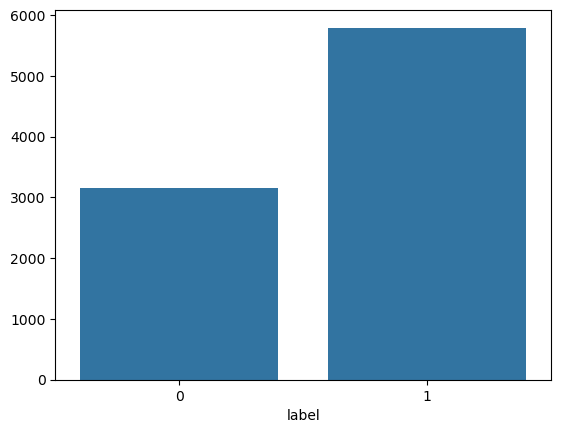

In [86]:
x = dfc['label'].value_counts()
sns.barplot(x=x.index, y=x.values)
plt.show()

Está bastante desequilibrado; hay muchos más textos que no son vulos que son vulos.

## 4.2 Tratamiento de los duplicados y de los nulos

Comprobación de duplicados

In [ ]:
print(dfc.duplicated().any())

False


No hay duplicados

Comporbación de si existen nulos y en que columnas se encuentran

In [ ]:
dfc.isnull().sum() 

label                   0
statement               0
subject                 0
speaker                 0
speaker_job          2482
state_info           1930
party_affiliation       0
dtype: int64

Al ser demasiados nulos intentaremos sacar la información de otras columnas

## 4.3 Tratamiento features

### 4.3.1 Feature Statement

- Statement

In [ ]:
# Obtener el conteo de valores únicos de 'speaker'
statement_counts = dfc['statement'].value_counts()

# Convertir a diccionario
statement_counts_dict = statement_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study-statement/statements.json', 'w', encoding='utf-8') as f:
    json.dump(statement_counts_dict, f, ensure_ascii=False, indent=2)

Poner todas las letras en minúscula

In [ ]:
dfc['statement'] = dfc['statement'].str.replace("Ill", "i'll")


In [ ]:
from collections import defaultdict
nlp = spacy.load('en_core_web_lg')
en_stopwords = nlp.Defaults.stop_words

#Collection
def create_collection(label):
    collection=[]
    
    for x in dfc[dfc['label']==label]['statement'].str.split():
        for i in x:
            collection.append(i)
    return collection

Common stopwords in no fake claims, label 0

In [ ]:

#Common stopwords in no fake claims, label 0
collection=create_collection(0)

dic=defaultdict(int)
for word in collection: 
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)
plt.show()

#Common stopwords in fake claims, label 1

In [ ]:
collection=create_collection(1)

dic=defaultdict(int)
for word in collection:
    if word in en_stopwords:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y,color='orange')
plt.show()

Como podemos comprobar que en tanto en fake claims como en no fake claims comparten palabras muy similares

In [ ]:
# Corrección de negaciones
# dfc['statement'] = dfc['statement'].str.replace("havent", "haven't")
# dfc['statement'] = dfc['statement'].str.replace("hasnt", "hasn't")
# dfc['statement'] = dfc['statement'].str.replace("didnt", "didn't")
# dfc['statement'] = dfc['statement'].str.replace("wont", "won't")
# dfc['statement'] = dfc['statement'].str.replace("wouldnt", "wouldn't")
# dfc['statement'] = dfc['statement'].str.replace("cant", "can't")
# dfc['statement'] = dfc['statement'].str.replace("couldnt", "couldn't")
# dfc['statement'] = dfc['statement'].str.replace("isnt", "isn't")
# dfc['statement'] = dfc['statement'].str.replace("arent", "aren't")
# dfc['statement'] = dfc['statement'].str.replace("shouldnt", "shouldn't")
# dfc['statement'] = dfc['statement'].str.replace("wasnt", "wasn't")
# dfc['statement'] = dfc['statement'].str.replace("werent", "weren't")
# dfc['statement'] = dfc['statement'].str.replace("dont", "don't")
# dfc['statement'] = dfc['statement'].str.replace("doesnt", "doesn't")
# dfc['statement'] = dfc['statement'].str.replace("mightnt", "mightn't")
# dfc['statement'] = dfc['statement'].str.replace("mustnt", "mustn't")
# dfc['statement'] = dfc['statement'].str.replace("neednt", "needn't")


import re

# Lista de palabras a reemplazar y sus reemplazos
replacements = {
    r'\bim\b': "i'm",
    r'\byoure\b': "you're",
    r'\bhes\b': "he's",
    r'\bshes\b': "she's",
    r'\bits\b': "it's",
    r'\btheyre\b': "they're",
    r'\byoud\b': "you'd",
    r'\bhed\b': "he'd",
    r'\bshed\b': "she'd",
    r'\bwed\b': "we'd",
    r'\btheyd\b': "they'd",
    r'\byoull\b': "you'll",
    r'\bhell\b': "he'll",
    r'\bshell\b': "she'll",
    r'\bitll\b': "it'll",
    r'\bwell\b': "we'll",
    r'\btheyll\b': "they'll",
    # hasnt
    r'\bhavent\b': "haven't",
    r'\bhasnt\b': "hasn't",
    r'\bdidnt\b': "didn't",
    r'\bwont\b': "won't",
    r'\bwouldnt\b': "wouldn't",
    r'\bcant\b': "can't",
    r'\bcouldnt\b': "couldn't",
    r'\bisnt\b': "isn't",
    r'\barent\b': "aren't",
    r'\bshouldnt\b': "shouldn't",
    r'\bwasnt\b': "wasn't",
    r'\bwerent\b': "weren't",
    r'\bdont\b': "don't",
    r'\bdoesnt\b': "doesn't",
    r'\bmightnt\b': "mightn't",
    r'\bmustnt\b': "mustn't",
    r'\bneednt\b': "needn't",
    r'\bwhyd\b': "why'd",
    r'\bwholl\b': "who'll",
    r'\bwhod\b': "who'd",
    r'\bwhos\b': "who's",
    r'\bwhats\b': "what's",
    r'\bwhens\b': "when's",
    r'\bwhys\b': "why's",
    r'\bwhereas\b': "where's",
    r'\bwhereve\b': "where've",
    r'\bwhodve\b': "who'd've",
    r'\bwhodnt\b': "who'dn't",
    r'\bwhodve\b': "who'd've",
}

# Función para aplicar los reemplazos
def replace_words(text):
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    return text

# Aplicar la función a la columna 'statement'
dfc['statement'] = dfc['statement'].apply(replace_words)

# Verificar el resultado en las primeras filas
print(dfc['statement'].head())

In [ ]:
oov_words_by_row = {}

In [ ]:
import re
import string
import spacy

nlp = spacy.load('en_core_web_lg')

# Contadores globales
digit_changes = 0
punct_changes = 0
url_changes = 0
stopword_changes = 0
not_changes = 0

# Palabras de negación completasstring.punctuation
negation_words = {
    "not", "never", "no", "nor", "cannot", "nobody", "none",
    "nothing", "nowhere", "neither", "can't", "dont", "won't", 
    "don't", "aren't", "isn't", "wasn't", "couldn't", 
    "shouldn't", "wouldn't", "didn't", "hasn't", "haven't", "hadn't"
}

# También detectaremos contracciones con n't
negation_suffixes = ("n't", "'t")

def preprocess(text, row_number=None):
    global digit_changes, punct_changes, url_changes, stopword_changes, not_changes

    text = re.sub(r'\s+', ' ', text).strip()

    text = replace_words(text)
    # return text
    doc = nlp(text)
    tokens = []
    oov_tokens = []



    for token in doc:
        # Eliminar URLs
        if token.like_url:
            url_changes += 1
            continue

        # Eliminar números
        if token.like_num:
            digit_changes += 1
            continue
        if any(char.isdigit() for char in token.text):
            digit_changes += 1
            continue

        # Eliminar puntuación y espacios
        if token.is_punct or token.is_space or token.text in string.punctuation:
            if token.is_punct:
                punct_changes += 1
            continue
        if any(char in string.punctuation for char in token.text):
            punct_changes += 1
            continue

        lower_token = token.text.lower()
        # Detectar negaciones completas o contracciones
        if lower_token == "wo":
            continue

        if lower_token in negation_words or lower_token.endswith(negation_suffixes):
            tokens.append("not")
            not_changes += 1
            continue

        # Eliminar stopwords
        if token.is_stop or token.text in nlp.Defaults.stop_words or token.text in {'m', 'll', 'd', 're', 's', 've', 't'}:
            stopword_changes += 1
            continue

        if token.is_oov:
            oov_tokens.append(token.text)

        # Agregar token limpio
        tokens.append(token.text)

    if row_number is not None and oov_tokens:
        oov_words_by_row[row_number] = oov_tokens


    clean = ' '.join(tokens)
    return clean

# ------------------- Sección de pruebas -------------------
if __name__ == "__main__":
    # ejemplos = [
    #     "MikeHuckabee.com aren't gets \"more hits than virtually any 43 other presidential candidate.\"",
    #     "you can't check out a library book without a photo ID",
    #     "Visit our site at example.com for more info!",
    #     "He won't be coming at 5pm.",negation_words or lower_token.endswith(negation_suffixes):
        #     tokens.append("not")
        #     continue
    #     "He wouldn't be coming at 5pm.",
    #     "123 Testing digits and punctuation!!!",
    #     "Nobody wolda has 2 apples, does he?"
    # ]

    ejemplos = [
        # "I'd not check library book photo ID",
        # "MikeHuckabee.com aren't gets \"more hits than virtually any 43 other presidential candidate.\"",
        # "The vast majority of the money I got was from small donors all across the country.''\tcampaign-finance\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\tan interview with CNBC's John Harwood \n5802.json\ttrue\tThe Democrat-controlled Senate, it hasnt passed a budget in more than 1,000 days.\tdeficit,federal-budget,job-accomplishments\tjohn-boehner\tSpeaker of the House of Representatives\tOhio\trepublican\t13\t22\t11\t4\t2\ta video address\n6153.json\thalf-true\tThe median income in America has dropped by 10 percent in the last four years.\teconomy,income,jobs\tmitt-romney\tFormer governor\tMassachusetts\trepublican\t34\t32\t58\t33\t19\ta speech\n6515.json\tbarely-true\tSays U.S. Senate hopeful Tammy Baldwin voted for a $1 trillion stimulus bill that included a wasteful $800,000 to replace light bulbs.\tenergy,federal-budget,stimulus\tcrossroads-gps\tConservative advocacy group\t\trepublican\t9\t1\t4\t1\t2\ta television ad\n385.json\ttrue\tSays Clinton did not read the National Intelligence Estimate before voting for the Iraq war.\tiraq\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\ta speech in Westerville, Ohio\n10932.json\tbarely-true\tThanks to the Act 10 collective bargaining law that took effect four years ago, ACT scores in Wisconsin are now second-best in the country for states where more than half the kids take the exam.\teducation,government-regulation,job-accomplishments,labor,unions\tscott-walker\tMilwaukee County Executive\tWisconsin\trepublican\t26\t41\t32\t40\t11\ta speech\n5076.json\tmostly-true\tOur income, our GDP per capita, is almost 50 percent higher than (it is for) the average European.\teconomy\tmitt-romney\tFormer governor\tMassachusetts\trepublican\t34\t32\t58\t33\t19\tan editorial board meeting with an Iowa newspaper\n12189.json\thalf-true\tSays Rick Scott cut Medicaid so people cant get Obamacare.\thealth-care,medicaid\trick-scotts-starbucks-heckler\tActivist, stay-at-home mom\tFlorida\tactivist\t0\t0\t2\t0\t0\ta confrontation with Rick Scott at Starbucks\n945.json\thalf-true\tThe stimulus bill includes $8 billion for high-speed rail projects, such as a 'magnetic levitation' line from Las Vegas to Disneyland.\""
        # "$$23123 $213 hjolas having asdf",
        # 'due', 'latter', 'least', 'these', "'m", 'all', 'almost', 'by', 'have', 'he', 'rather', 'without', 'are', 'about', 'were', 'sometimes', 'we', 'still', 'they', 'third', 'none', 'via', 'around', 'yourself', 'full', 'some', '‘ll', 'neither', 'namely', '’d', 'further', 'forty', 'always', 'be', 'anything', 'afterwards', 'therein', 'former', 'others', 'already', 'another', 'a', 'make', 'every', 'so', 'together', 'his', 'beforehand', 'must', 'used', 'for', 'yours', 'themselves', 'with', 'could', 'only', 'fifty', 'beyond', 'per', 'seems', 'regarding', 'six', 'beside', 'nine', 'also', 'nevertheless', 'empty', 'say', 'often', 'meanwhile', 'first', 'how', 'somehow', 'eight', 'anyone', 'therefore', 'does', 'up', 'over', 'sixty', 'it', 'becomes', 'into', 'behind', '‘d', 'once', 'less', 'see', 'what', 'much', 'name', 'her', 'thus', 'itself', 'should', 'you', 'move', 'fifteen', 'myself', 'amongst', 'whether', 'but', 'this', 'eleven', 'out', 'perhaps', 'whatever', 'never', '’m', 'whither', 'to', 'him', 'same', 'whence', 'who', '’ll', 'four', 'its', 'our', 'back', 'thence', 'throughout', 'has', 'that', 'otherwise', 'side', 'after', 'show', 'done', 'few', 'top', 'whereupon', 'yet', 'both', 'three', 'been', 'us', 'me', 'will', 'herself', 'between', 'them', 'thereby', '‘ve', 'either', 'can', "'ll", 'next', 'hers', 'those', 'twelve', 'i', 'thru', 'thereupon', 'upon', 'toward', 'himself', 'of', 'seeming', 'though', 'twenty', '’ve', 'n‘t', 'noone', 're', 'something', 'among', 'nowhere', 'wherein', '‘re', 'hundred', 'above', 'ten', 'elsewhere', 'and', 'many', 'my', 'whom', 'as', 'than', 'give', 'under', 'very', 'was', 'indeed', 'anywhere', 'now', 'put', 'hereafter', 'if', 'part', 'against', 'go', 'she', 'mostly', 'through', 'quite', 'doing', 'last', 'hereby', 'which', 'on', 'everything', '‘m', 'wherever', 'along', 'down', 'formerly', 'become', 'why', 'whereby', 'had', 'latterly', 'again', 'below', 'each', 'five', 'several', 'is', 'alone', 'well', 'hereupon', 'whoever', 'else', 'onto', 'no', 'made', 'herein', 'sometime', 'whole', 'own', 'please', 'get', '’re', 'being', 'serious', "'d", 'towards', 'even', 'here', 'might', 'mine', 'using', 'ever', 'call', 'there', 'when', 'keep', 'although', 'during', 'moreover', 'your', 'everyone', "'s", 'or', 'various', 'until', 'an', 'within', 'bottom', 'becoming', 'whenever', 'whereafter', 'whose', 'anyway', 'nothing', 'at', 'take', "'re", 'n’t', 'the', 'not', 'am', 'besides', 'such', 'in', 'unless', 'ourselves', 'nor', 'more', 'most', '’s', 'since', 'seem', "n't", 'their', 'one', 'where', 'may', 'amount', 'yourselves', "'ve", 'except', 'too', 'everywhere', 'while', 'hence', 'would', 'became', 'really', 'any', 'just', 'thereafter', 'cannot', 'somewhere', 'seemed', 'off', 'from', 'did', 'do', 'anyhow', 'front', 'two', 'enough', 'someone', 'before', 'other', '‘s', 'however', 'across', 'ca', 'then', 'because', 'ours', 'nobody', 'whereas'}
        # "due latter least these 'm all almost by have he rather without are about were sometimes we still they third none via around yourself full some ‘ll neither namely ’d further forty always be anything afterwards therein former others already another a make every so together his beforehand must used for yours themselves with could only fifty beyond per seems regarding six beside nine also nevertheless empty say often meanwhile first how somehow eight anyone therefore does up over sixty it becomes into behind ‘d once less see what much name her thus itself should you move fifteen myself amongst whether but this eleven out perhaps whatever never ’m whither to him same whence who ’ll four its our back thence throughout has that otherwise side after show done few top whereupon yet both three been us me will hersel"
        # "China is in the South China Sea and (building)a military fortress the likes of which perhaps the  filia world has not seen. ",
        
        # "says76 percent voters united states want johnson weld presidential debates"

    ]

    for s in ejemplos:
        print(f"Original: {s}")
        resultado = preprocess(s,1)
        print(f"Procesado: {resultado}\n")

    print(f"URLs eliminadas: {url_changes}")
    print(f"Puntuaciónes eliminadas: {punct_changes}")
    print(f"Stopwords eliminadas: {stopword_changes}")
    print(f"Dígitos eliminados: {digit_changes}")


In [ ]:
# # Función para lematizar los verbos en una frase
def lemmatize_verbs(text):
    doc = nlp(text)
    lemmatized_text = []
    for token in doc:
        # Si el token es un verbo, usar su lema; de lo contrario, mantener el texto original
        if token.pos_ == "VERB":
            lemmatized_text.append(token.lemma_)
        else:
            lemmatized_text.append(token.text)
    return " ".join(lemmatized_text)



Como podemos comprobar no hay una gran diferencia entre ambos tipos de *claims*

In [ ]:
# Stop words
print(nlp.Defaults.stop_words)

In [ ]:
import string

print(string.punctuation)

### Raw

In [ ]:
# i = 0
# dfc['statement'] = dfc['statement'].apply(lambda x: preprocess(x, row_number=i))
dfc['statement'] = dfc.apply(lambda row: preprocess(row['statement'], row.name), axis=1)
dfc['statement-raw']  = dfc['statement']
dfc['statement-raw'] = dfc['statement-raw'].apply(lambda x: x.lower())


# Mostrar los contadores
print(f"URLs eliminadas: {url_changes}")
print(f"Puntuaciones eliminadas: {punct_changes}")
print(f"Stopwords eliminadas: {stopword_changes}")
print(f"Dígitos eliminados: {digit_changes}")

In [ ]:
def create_collection_raw(label):
    collection=[]
    
    for x in dfc[dfc['label']==label]['statement-raw'].str.split():
        for i in x:
            collection.append(i)
    return collection

#Common stopwords in no fake claims, label 0
collection=create_collection_raw(0)

dic=defaultdict(int)
for word in collection: 
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)
plt.show()

In [ ]:
collection=create_collection_raw(1)

dic=defaultdict(int)
for word in collection: 
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y, color='orange')
plt.show()

### Lematize

In [ ]:
dfc['statement-leamtize'] = dfc['statement'].apply(lambda x: lemmatize_verbs(x))
dfc['statement-leamtize'] = dfc['statement-leamtize'].apply(lambda x: x.lower())

In [ ]:
import json

# Función para guardar el diccionario en un archivo JSON
def save_oov_to_json(oov_dict, output_file="./json-study-statement/oov_words_by_row.json"):
    """
    Guarda el diccionario de palabras fuera del vocabulario (OOV) en un archivo JSON.

    :param oov_dict: Diccionario con las palabras OOV por fila.
    :param output_file: Nombre del archivo JSON de salida.
    """
    try:
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(oov_dict, f, ensure_ascii=False, indent=4)
        print(f"Diccionario OOV guardado en: {output_file}")
    except Exception as e:
        print(f"Error al guardar el archivo JSON: {e}")

# Guardar el diccionario OOV en un archivo JSON

save_oov_to_json(oov_words_by_row)

In [ ]:
# Obtener el conteo de valores únicos de 'speaker'
# statement_counts = dfc_backup['statement'].value_counts()
statement_counts = dfc['statement-leamtize']

# Convertir a diccionario
statement_counts_dict = statement_counts.to_dict()

# Exportar a un archivo JSON
with open('json-study-statement/statements_v1.json', 'w', encoding='utf-8') as f:
    json.dump(statement_counts_dict, f, ensure_ascii=False, indent=2)

In [ ]:
def create_collection_lematize(label):
    collection=[]
    
    for x in dfc[dfc['label']==label]['statement-leamtize'].str.split():
        for i in x:
            collection.append(i)
    return collection

#Common stopwords in no fake claims, label 0
collection=create_collection_lematize(0)

dic=defaultdict(int)
for word in collection: 
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)
plt.show()

In [ ]:
collection=create_collection_lematize(1)

dic=defaultdict(int)
for word in collection:
    if word in en_stopwords:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y,color='orange')
plt.show()

In [ ]:
dfc.head()

# dfc.drop(columns='label', inplace=True)

### 4.3.2 Resto de features

#### - subject

In [ ]:
# dfc = df.copy()

# dfc['subject'].value_counts()

dfc['subject'].iloc[1:10]                    

In [ ]:
dfc['subject'] = dfc['subject'].str.lower()
dfc['subject_list'] = (
    dfc['subject']
    .str.split(',')
    .apply(lambda lst: [s.strip() for s in lst if s.strip()])
)

# 3. “Explode” para tener una fila por cada etiqueta y contar
subjects_exploded = dfc.explode('subject_list')
subject_counts = subjects_exploded['subject_list'].value_counts()
print(subject_counts)
# 4. Convertir a diccionario
subject_count_dict = subject_counts.to_dict()
with open('json-study/subject_counts.json', 'w', encoding='utf-8') as f:
    json.dump(subject_count_dict, f, ensure_ascii=False, indent=2)

# dfc['subject_list'].iloc[1:10]


##### maping

In [ ]:
subject_mapping = {
    # economia_y_finanzas
    "economy": "subject-economia_y_finanzas",
    "taxes": "subject-economia_y_finanzas",
    "federal-budget": "subject-economia_y_finanzas",
    "state-budget": "subject-economia_y_finanzas",
    "income": "subject-economia_y_finanzas",
    "debt": "subject-economia_y_finanzas",
    "deficit": "subject-economia_y_finanzas",
    "market-regulation": "subject-economia_y_finanzas",
    "corporations": "subject-economia_y_finanzas",
    "stimulus": "subject-economia_y_finanzas",
    "small-business": "subject-economia_y_finanzas",
    "bankruptcy": "subject-economia_y_finanzas",
    "government-regulation": "subject-economia_y_finanzas",
    "financial-regulation": "subject-economia_y_finanzas",
    "housing": "subject-economia_y_finanzas",
    "agriculture": "subject-economia_y_finanzas",
    "poverty": "subject-economia_y_finanzas",
    "retirement": "subject-economia_y_finanzas",
    "pensions": "subject-economia_y_finanzas",

    # salud_y_bienestar
    "health-care": "subject-salud_y_bienestar",
    "medicare": "subject-salud_y_bienestar",
    "medicaid": "subject-salud_y_bienestar",
    "public-health": "subject-salud_y_bienestar",
    "disability": "subject-salud_y_bienestar",
    "drugs": "subject-salud_y_bienestar",
    "abortion": "subject-salud_y_bienestar",
    "hunger": "subject-salud_y_bienestar",
    "ebola": "subject-salud_y_bienestar",
    "autism": "subject-salud_y_bienestar",
    "marijuana": "subject-salud_y_bienestar",
    "welfare": "subject-salud_y_bienestar",

    # Educación
    "education": "subject-educacion",
    "children": "subject-educacion",

    # trabajo_y_empleo
    "jobs": "subject-trabajo_y_empleo",
    "labor": "subject-trabajo_y_empleo",
    "workers": "subject-trabajo_y_empleo",
    "unions": "subject-trabajo_y_empleo",
    "job-accomplishments": "subject-trabajo_y_empleo",

    # Política y Gobierno
    "elections": "subject-politica_y_gobierno",
    "candidates-biography": "subject-politica_y_gobierno",
    "congress": "subject-politica_y_gobierno",
    "state-finances": "subject-politica_y_gobierno",
    "city-government": "subject-politica_y_gobierno",
    "county-government": "subject-politica_y_gobierno",
    "campaign-finance": "subject-politica_y_gobierno",
    "voting-record": "subject-politica_y_gobierno",
    "transparency": "subject-politica_y_gobierno",
    "debates": "subject-politica_y_gobierno",
    "redistricting": "subject-politica_y_gobierno",
    "congressional-rules": "subject-politica_y_gobierno",
    "polls": "subject-politica_y_gobierno",
    "government-efficiency": "subject-politica_y_gobierno",
    "campaign-advertising": "subject-politica_y_gobierno",
    "bipartisanship": "subject-politica_y_gobierno",
    "infrastructure": "subject-politica_y_gobierno",
    "transportation": "subject-politica_y_gobierno",
    "message-machine": "subject-politica_y_gobierno",
    "message-machine-2012": "subject-politica_y_gobierno",
    "message-machine-2014": "subject-politica_y_gobierno",
    "states": "subject-politica_y_gobierno",

    # Seguridad y Justicia
    "crime": "subject-seguridad_y_justicia",
    "criminal-justice": "subject-seguridad_y_justicia",
    "legal-issues": "subject-seguridad_y_justicia",
    "public-safety": "subject-seguridad_y_justicia",
    "death-penalty": "subject-seguridad_y_justicia",
    "terrorism": "subject-seguridad_y_justicia",
    "homeland-security": "subject-seguridad_y_justicia",
    "supreme-court": "subject-seguridad_y_justicia",
    "consumer-safety": "subject-seguridad_y_justicia",
    "privacy": "subject-seguridad_y_justicia",
    "guns": "subject-seguridad_y_justicia",
    "social-security": "subject-seguridad_y_justicia",

    # Relaciones Internacionales
    "foreign-policy": "subject-relaciones_internacionales",
    "military": "subject-relaciones_internacionales",
    "iraq": "subject-relaciones_internacionales",
    "afghanistan": "subject-relaciones_internacionales",
    "china": "subject-relaciones_internacionales",
    "israel": "subject-relaciones_internacionales",
    "trade": "subject-relaciones_internacionales",
    "nuclear": "subject-relaciones_internacionales",
    "islam": "subject-relaciones_internacionales",

    # Medio Ambiente y Energía
    "energy": "subject-medio_ambiente_y_energia",
    "climate-change": "subject-medio_ambiente_y_energia",
    "oil-spill": "subject-medio_ambiente_y_energia",
    "environment": "subject-medio_ambiente_y_energia",
    "water": "subject-medio_ambiente_y_energia",
    "cap-and-trade": "subject-medio_ambiente_y_energia",
    "natural-disasters": "subject-medio_ambiente_y_energia",

    # Sociedad y Cultura
    "religion": "subject-sociedad_y_cultura",
    "gays-and-lesbians": "subject-sociedad_y_cultura",
    "women": "subject-sociedad_y_cultura",
    "families": "subject-sociedad_y_cultura",
    "marriage": "subject-sociedad_y_cultura",
    "civil-rights": "subject-sociedad_y_cultura",
    "immigration": "subject-sociedad_y_cultura",
    "diversity": "subject-sociedad_y_cultura",
    "sexuality": "subject-sociedad_y_cultura",
    "ethics": "subject-sociedad_y_cultura",
    "history": "subject-sociedad_y_cultura",
    "pundits": "subject-sociedad_y_cultura",
    "human-rights": "subject-sociedad_y_cultura",
    "pop-culture": "subject-sociedad_y_cultura",
    "colbert-report": "subject-sociedad_y_cultura",
    "population": "subject-sociedad_y_cultura",

    # Ciencia y Tecnología
    "science": "subject-ciencia_y_tecnologia",
    "space": "subject-ciencia_y_tecnologia",

    # Otros / Misceláneos
    "sports": "subject-otros",
    "fake-news": "subject-otros",
    "food": "subject-otros",
    "baseball": "subject-otros",
    "recreation": "subject-otros",
    "weather": "subject-otros",
    "food-safety": "subject-otros",
    "patriotism": "subject-otros",
    "nightlife": "subject-otros",
    "lottery": "subject-otros",
    "after-the-fact": "subject-otros",
    "urban": "subject-otros",
    "animals": "subject-otros",
    "gambling": "subject-otros",
    "alcohol": "subject-otros",
    "tourism": "subject-otros",
    "census": "subject-otros",
    "homeless": "subject-otros",
    "veterans": "subject-otros",
    "wealth": "subject-otros",
    "county-budget": "subject-otros",
    "city-budget": "subject-otros",
    "new-hampshire-2012": "subject-otros",
    "sotomayor-nomination": "subject-otros",
    "kagan-nomination": "subject-otros",
    "occupy-wall-street": "subject-otros",
    "florida": "subject-otros",
    "florida-amendments": "subject-otros",
    "public-service": "subject-otros",
    "gas-prices": "subject-otros",
    "bush-administration": "subject-otros",
    "obama-birth-certificate": "subject-otros",
    "10-news-tampa-bay": "subject-otros",
    "abc-news-week": "subject-otros",
    "corrections-and-updates": "subject-otros",
}


In [ ]:
# Aplicamos el mapeo al DataFrame
subjects_exploded['subject_category'] = subjects_exploded['subject_list'].map(subject_mapping).fillna('subject-otros')

# Obtenemos los conteos por nueva categoría
category_counts = subjects_exploded['subject_category'].value_counts()

print(category_counts)
subjects_exploded['subject_category'].iloc[1:10]

##### next

Vamos a cortar el diccionario por el 1% de los datos para evitar posible overfiting

In [ ]:
# percentage = 0.01
# num_filas = dfc.shape[0]
# cut_count_namber = int(num_filas * percentage)
# print("Número de filas para el corte:", cut_count_namber)

# from sklearn.preprocessing import MultiLabelBinarizer
# df2 = dfc.copy()

# frequent_subjects = set(subject_counts[subject_counts >= cut_count_namber].index)

# # Sustituir las etiquetas raras por 'other_subject'
# df2['subject_list_clean'] = df2['subject_list'].apply(
#     lambda lst: [s if s in frequent_subjects else 'other_topics' for s in lst]
# )

# # Binariza con MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# onehot = mlb.fit_transform(df2['subject_list_clean'])

# # DataFrame de one-hot y concatenación
# df_subjects_onehot = pd.DataFrame(
#     onehot,
#     columns=mlb.classes_,
#     index=df2.index
# )

# df2 = pd.concat([df2, df_subjects_onehot], axis=1)

# # df2.head()
# df2.shape

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


# --- 2) Mapea cada subject a su categoría y quita duplicados ---
dfc['subject_categories'] = dfc['subject_list'].apply(
    lambda lst: list({
        subject_mapping.get(s, 'subject-otros') 
        for s in lst
    })
)

# (Opcional) echa un vistazo:
print(dfc[['subject_list','subject_categories']].head())

# --- 3) One-Hot Binarizer sobre la lista de categorías ---
mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(dfc['subject_categories'])

# Construye el DataFrame de one-hot
df_onehot = pd.DataFrame(
    onehot,
    columns=mlb.classes_,
    index=dfc.index
)


dfc = pd.concat([dfc, df_onehot], axis=1)

print(dfc.shape)
dfc.head()


In [ ]:
dfc.drop(columns='subject', inplace=True)
dfc.drop(columns='subject_list', inplace=True)
dfc.drop(columns='subject_categories', inplace=True)

print(dfc.columns)

#### - Speaker

In [ ]:
# Obtener el conteo de valores únicos de 'speaker'
speaker_counts = dfc['speaker'].value_counts()
speaker_counts_test = df_test['speaker'].value_counts()

# Convertir a diccionario
speaker_counts_dict = speaker_counts.to_dict()
speaker_counts_test_dict = speaker_counts_test.to_dict()

# Exportar a un archivo JSON
with open('json-study/speaker_counts.json', 'w', encoding='utf-8') as f:
    json.dump(speaker_counts_dict, f, ensure_ascii=False, indent=2)

with open('json-study/speaker_counts_test.json', 'w', encoding='utf-8') as f:
    json.dump(speaker_counts_test_dict, f, ensure_ascii=False, indent=2)

Utilizando los archivos JSON json-study/speaker_counts_test.json y json-study/speaker_counts_test.json, que contienen los conteos de apariciones de cada speaker tanto en el conjunto de entrenamiento como en el de prueba, se ha obtenido la lista de los 20 speakers más frecuentes en el conjunto de prueba.

Al analizar dicha lista, se observa que a partir del décimo speaker se produce una disminución significativa en la frecuencia de aparición. Por tanto, este punto podría considerarse un umbral razonable para realizar un corte: mantener los 10 speakers más frecuentes como categorías individuales y agrupar el resto bajo una categoría común, como "other_speakers". Esta decisión busca reducir el riesgo de overfitting y mejorar la capacidad de generalización del modelo.

<small>

| ID  | Name               | dfc | df_test |
|-----|--------------------|-----|---------|
| 1   | barack-obama       | 435 | 176     |
| 2   | donald-trump       | 247 | 96      |
| 3   | hillary-clinton    | 204 | 93      |
| 4   | mitt-romney        | 142 | 70      |
| 5   | john-mccain        | 139 | 50      |
| 6   | chain-email        | 128 | 50      |
| 7   | scott-walker       | 123 | 60      |
| 8   | rick-perry         | 117 | 56      |
| 9   | rick-scott         | 105 | 45      |
| 10  | marco-rubio        | 99  | 54      |
| 11  | ted-cruz           | 82  | 36      |
| 12  | bernie-s           | 75  | 31      |
| 13  | facebook-posts     | 75  | 25      |
| 14  | chris-christie     | 74  | 30      |
| 15  | charlie-crist      | 62  | 28      |
| 16  | newt-gingrich      | 62  | 21      |
| 17  | jeb-bush           | 60  | 19      |
| 18  | blog-posting       | 57  | 24      |
| 19  | joe-biden          | 54  | 22      |
| 20  | paul-ryan          | 50  | 20      |

</small>


In [ ]:
# Elegimos por donde cortar
top_n = 10
frequent_speakers = set(speaker_counts.head(top_n).index)

In [ ]:
# 4. Agrupar los menos frecuentes como 'other_speakers'
dfc['speaker_grouped'] = dfc['speaker'].apply(
    lambda s: s if s in frequent_speakers else 'other_speakers'
)

dfc['speaker_grouped'].value_counts()

In [ ]:
dfc.drop(columns='speaker', inplace=True)
dfc.head()

#### - speaker_job

In [ ]:
dfc['speaker_job'] = (
    dfc['speaker_job']
    .str.lower()
    .str.strip()
    .str.replace(r'\s+', '_', regex=True)
)

# Obtener el conteo de valores únicos de 'speaker'
speaker_job_counts = dfc['speaker_job'].value_counts()
speaker_job_counts_test = df_test['speaker_job'].value_counts()


# Convertir a diccionario
speaker_job_counts_dict = speaker_job_counts.to_dict()
speaker_job_counts_test_dict = speaker_job_counts_test.to_dict()

# Exportar a un archivo JSON
with open('json-study/speaker_job_counts.json', 'w', encoding='utf-8') as f:
    json.dump(speaker_job_counts_dict, f, ensure_ascii=False, indent=2)

with open('json-study/speaker_job_counts_test.json', 'w', encoding='utf-8') as f:
    json.dump(speaker_job_counts_test_dict, f, ensure_ascii=False, indent=2)

Utilizando los archivos JSON json-study/speaker__job_counts_test.json y json-study/speaker_job_counts_test.json, que contienen los conteos de apariciones de cada speaker_job tanto en el conjunto de entrenamiento como en el de prueba, se ha obtenido la lista de los 20 speakers_jobs más frecuentes en el conjunto de prueba.

Al analizar dicha lista, se observa que a partir del treceavo speaker_job se produce una disminución significativa en la frecuencia de aparición. Por tanto, este punto podría considerarse un umbral razonable para realizar un corte: mantener los 13 speakers_jobs más frecuentes como categorías individuales y agrupar el resto bajo una categoría común, como "other_speakers_job". Esta decisión busca reducir el riesgo de overfitting y mejorar la capacidad de generalización del modelo.

<small>

| id  | speaker_job                                | train_count | test_count |
|-----|--------------------------------------------|-------------|------------|
| 1   | u_s__senator                               | 627         | 204        |
| 2   | president                                  | 438         | 177        |
| 3   | governor                                   | 368         | 152        |
| 4   | u_s__representative                        | 260         | 61         |
| 5   | president-elect                            | 247         | 96         |
| 6   | presidential_candidate                     | 216         | 99         |
| 7   | state_senator                              | 186         | 36         |
| 8   | state_representative                       | 155         | 30         |
| 9   | former_governor                            | 143         | 70         |
| 10  | senator                                    | 129         | 64         |
| 11  | milwaukee_county_executive                 | 123         | 60         |
| 12  | attorney                                   | 94          | 32         |
| 13  | u_s__house_of_representatives              | 81          | 37         |
| 14  | social_media_posting                       | 75          | 25         |
| 15  | governor_of_new_jersey                     | 74          | 30         |
| 16  | congressman                                | 70          | 38         |
| 17  | co-host_on_cnn_s__crossfire                | 66          | 22         |
| 18  | u_s__congressman                           | 56          | 26         |
| 19  | speaker_of_the_house_of_representatives    | 49          | 23         |
| 20  | congresswoman                              | 49          | 18         |

</small>


In [ ]:
# Elegir el punto de corte (por ejemplo, los 10 más frecuentes)
top_n = 13
frequent_speaker_jobs = set(speaker_job_counts.head(top_n).index)

In [ ]:
# Agrupar los menos frecuentes como 'other_speaker_jobs'
dfc['speaker_job_grouped'] = dfc['speaker_job'].apply(
    lambda job: job if job in frequent_speaker_jobs else 'other_speaker_jobs'
)

# Ver el resultado final
dfc['speaker_job_grouped'].value_counts()


In [ ]:
dfc.drop(columns='speaker_job', inplace=True)
dfc.head()

#### - state_info

In [ ]:
# Obtener el conteo de valores únicos de 'speaker'
state_info_counts = dfc['state_info'].value_counts()
state_info_counts_test = df_test['state_info'].value_counts()


# Convertir a diccionario
state_info_counts_dict = state_info_counts.to_dict()
state_info_counts_test_dict = state_info_counts_test.to_dict()

# Exportar a un archivo JSON
with open('json-study/state_info_counts.json', 'w', encoding='utf-8') as f:
    json.dump(state_info_counts_dict, f, ensure_ascii=False, indent=2)

with open('json-study/state_info_counts_test.json', 'w', encoding='utf-8') as f:
    json.dump(state_info_counts_test_dict, f, ensure_ascii=False, indent=2)

| Número | Estado               | Train | Test |
|--------|----------------------|-------|------|
| 1      | Texas                | 879   | 380  |
| 2      | Florida              | 853   | 378  |
| 3      | Wisconsin            | 648   | 252  |
| 4      | New York             | 579   | 250  |
| 5      | Illinois             | 487   | 205  |
| 6      | Ohio                 | 408   | 178  |
| 7      | Georgia              | 381   | 164  |
| 8      | Virginia             | 368   | 144  |
| 9      | Rhode Island         | 317   | 135  |
| 10     | New Jersey           | 209   | 96   |
| 11     | Oregon               | 220   | 87   |
| 12     | Massachusetts        | 167   | 83   |
| 13     | Arizona              | 160   | 68   |
| 14     | California           | 121   | 59   |
| 15     | Washington, D.C.     | 89    | 52   |
| 16     | Vermont              | 80    | 37   |
| 17     | New Hampshire        | 79    | 28   |
| 18     | Pennsylvania         | 79    | 33   |
| 19     | Arkansas             | 77    | 26   |
| 20     | Kentucky             | 72    | 26   |


Utilizando los archivos JSON json-study/state_info_counts_test.json y json-study/state_info_counts.json, que contienen los conteos de apariciones de cada estado tanto en el conjunto de entrenamiento como en el de prueba, se ha obtenido la lista de los 20 estados más frecuentes en el conjunto de prueba.

Al analizar dicha lista, se observa que a partir del quinceavo estado se produce una disminución significativa en la frecuencia de aparición. Por tanto, este punto podría considerarse un umbral razonable para realizar un corte: mantener los 15 estados más frecuentes como categorías individuales y agrupar el resto bajo una categoría común, como "other_states". Esta decisión busca reducir el riesgo de overfitting y mejorar la capacidad de generalización del modelo.

In [ ]:
# Obtener el conteo de valores únicos de 'state_info'
state_info_counts = dfc['state_info'].value_counts()

# Elegir el punto de corte (por ejemplo, los 10 más frecuentes)
top_n = 15
frequent_state_info = set(state_info_counts.head(top_n).index)

In [ ]:
# Agrupar los menos frecuentes como 'other_state_info'
dfc['state_info_grouped'] = dfc['state_info'].apply(
    lambda info: info if info in frequent_state_info else 'other_state_info'
)

# 6. Ver el resultado final
dfc['state_info_grouped'].value_counts()

In [ ]:
dfc.drop(columns='state_info', inplace=True)
dfc.head()

#### - party_affiliation

In [ ]:
# dfc['party_affiliation'].value_counts()       

# Obtener el conteo de valores únicos de 'speaker'
party_affiliation_counts = dfc['party_affiliation'].value_counts()
party_affiliation_counts_test = df_test['party_affiliation'].value_counts()


# Convertir a diccionario
party_affiliation_counts_dict = party_affiliation_counts.to_dict()
party_affiliation_counts_dict_test = party_affiliation_counts_test.to_dict()

# Exportar a un archivo JSON
with open('json-study/party_affiliation_counts.json', 'w', encoding='utf-8') as f:
    json.dump(party_affiliation_counts_dict, f, ensure_ascii=False, indent=2)

with open('json-study/party_affiliation_counts_test.json', 'w', encoding='utf-8') as f:
    json.dump(party_affiliation_counts_dict, f, ensure_ascii=False, indent=2)


In [ ]:
mapping = {
    # Major parties
    'republican': 'republican',
    'democrat': 'democrat',
    'democratic-farmer-labor': 'democrat',

    # Independents / None
    'none': 'independent_None',
    'independent': 'independent_None',
    'newsmaker': 'independent_None',
    'journalist': 'independent_None',
    'columnist': 'independent_None',
    'activist': 'independent_None',
    'talk-show-host': 'independent_None',

    # Third parties
    'libertarian': 'third_Party',
    'green': 'third_Party',
    'constitution-party': 'third_Party',
    'liberal-party-canada': 'third_Party',

    # Organizations
    'organization': 'organization',
    
    # Officials  
    'state-official': 'official',
    'business-leader': 'official',
    'labor-leader': 'official',
    'education-official': 'official',
    'government-body': 'official',

    # Tea Party
    'tea-party-member': 'republican',
    'ocean-state-tea-party-action': 'republican',
}

def group_party(x):
    return mapping.get(x, 'other')  # anything else → 'Other'



In [ ]:
dfc['party_group'] = dfc['party_affiliation'].apply(group_party)

# Recuento de las nuevas categorías
print(dfc['party_group'].value_counts())


In [ ]:
dfc.drop(columns='party_affiliation', inplace=True)
dfc.head()


# 7. Create Test

In [ ]:
dfa = df_test.copy() # Backup del dataframe original
dfa.dtypes.sort_index()

In [ ]:
# Opcional: Eliminar filas con valores nulos en el DataFrame 'df_test'
# df_test = df_test.dropna()

# # Mostrar la cantidad de valores nulos restantes en 'df_test'
print(df_test.isnull().sum())

### - statements

In [ ]:
dfa['statement'] = dfa['statement'].str.replace("Ill", "i'll")

dfa['statement'] = dfa.apply(lambda row: preprocess(row['statement'], row.name), axis=1)
dfa['statement-raw']  = dfa['statement']
dfa['statement-raw'] = dfa['statement-raw'].apply(lambda x: x.lower())

# Mostrar los contadores
print(f"URLs eliminadas: {url_changes}")
print(f"Puntuaciones eliminadas: {punct_changes}")
print(f"Stopwords eliminadas: {stopword_changes}")
print(f"Dígitos eliminados: {digit_changes}")

In [ ]:
dfa['statement-leamtize'] = dfa['statement'].apply(lambda x: lemmatize_verbs(x))
dfa['statement-leamtize'] = dfa['statement-leamtize'].apply(lambda x: x.lower())

### - subject

In [ ]:
dfa['subject'] = dfa['subject'].str.lower()
dfa['subject_list'] = (
    dfa['subject']
    .str.split(',')
    .apply(lambda lst: [s.strip() for s in lst if s.strip()])
)

# --- 2) Mapea cada subject a su categoría y quita duplicados ---
dfa['subject_categories'] = dfa['subject_list'].apply(
    lambda lst: list({
        subject_mapping.get(s, 'subject-otros') 
        for s in lst
    })
)

# (Opcional) echa un vistazo:
print(dfa[['subject_list','subject_categories']].head())

# --- 3) One-Hot Binarizer sobre la lista de categorías ---
mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(dfa['subject_categories'])

# Construye el DataFrame de one-hot
dfa_onehot = pd.DataFrame(
    onehot,
    columns=mlb.classes_,
    index=dfa.index
)


dfa = pd.concat([dfa, dfa_onehot], axis=1)

print(dfa.shape)
dfa.head()


### - speaker

In [ ]:
# 4. Agrupar los menos frecuentes como 'other_speakers'
dfa['speaker_grouped'] = dfa['speaker'].apply(
    lambda s: s if s in frequent_speakers else 'other_speakers'
)

dfa['speaker_grouped'].value_counts()

### - speaker_job

In [ ]:
# Agrupar los menos frecuentes como 'other_speaker_jobs'
dfa['speaker_job_grouped'] = dfa['speaker_job'].apply(
    lambda job: job if job in frequent_speaker_jobs else 'other_speaker_jobs'
)

# Ver el resultado final
dfa['speaker_job_grouped'].value_counts()

### - state_info

In [ ]:
# Agrupar los menos frecuentes como 'other_state_info'
dfa['state_info_grouped'] = dfa['state_info'].apply(
    lambda info: info if info in frequent_state_info else 'other_state_info'
)

# 6. Ver el resultado final
dfa['state_info_grouped'].value_counts()

### - party_affiliation

In [ ]:
dfa['party_group'] = dfa['party_affiliation'].apply(group_party)

# Recuento de las nuevas categorías
print(dfa['party_group'].value_counts())


In [ ]:
dfa.drop(columns='id', inplace=True)
dfa.drop(columns='subject', inplace=True)
dfa.drop(columns='subject_list', inplace=True)
dfa.drop(columns='subject_categories', inplace=True)
dfa.drop(columns='speaker', inplace=True)
dfa.drop(columns='speaker_job', inplace=True)
dfa.drop(columns='state_info', inplace=True)
dfa.drop(columns='party_affiliation', inplace=True)


# 8. Exportar CSV

Comparar los dos dataset para ver que todo esta bien

In [ ]:
# Comparar las columnas de dfc y df_testn
columns_dfc = set(dfc.columns)
columns_df_testn = set(dfa.columns)

# Encontrar las diferencias
differences = columns_dfc.symmetric_difference(columns_df_testn)

# Verificar si la única diferencia es 'id'
if differences == {'id', 'label'}:
    print("La única diferencia entre las columnas es 'id' y 'label'.")
else:
    print("Existen otras diferencias en las columnas:", differences)

Guardar en *formated* los csv train y test

In [ ]:
# Exportar el DataFrame 'dfn' a un archivo CSV
dfc.to_csv('./formated/train_exportado.csv', index=False)

dfa.to_csv('./formated/test_exportado.csv', index=False)

Todas las features:

# 9. Referencias

* [Alexisbcook. (2023, 21 abril). Categorical variables. Kaggle.](https://www.kaggle.com/code/alexisbcook/categorical-variables)
* [pandas documentation — pandas 2.2.3 documentation. (s. f.).](https://pandas.pydata.org/docs/)